In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.3.0'

In [2]:
raw_dataset = pd.read_csv('orders.csv')
df = raw_dataset.copy()

In [3]:
parts_of_day = list(map(lambda t: datetime.strptime(t, '%H:%M').time(), 
                        ["00:00", "06:00", "12:00", "18:00", "23:00"]))


def part_of_day(date, parts):
    date = datetime.strptime(date, '%m/%d/%Y %H:%M').time()

    if parts_of_day[0] >= date < parts[1]:
        return 1

    if parts_of_day[1] >= date < parts[2]:
        return 2

    if parts_of_day[2] >= date < parts[3]:
        return 3

    return 4

def distnace(lat1, lon1, lat2, lon2):
  cos_l1 = np.cos(lat1)
  cos_l2 = np.cos(lat2)
  sin_l1 = np.sin(lat1)
  sin_l2 = np.sin(lat2)
  delta = lon1 - lon2

  y = np.sqrt(np.square(cos_l2 * np.sin(delta)) + np.square(cos_l1 * sin_l2 - sin_l1 * cos_l2 * np.cos(delta)))
  x = sin_l1 * sin_l2 + cos_l1 * cos_l2 * np.cos(delta)
  return np.arctan2(y, x) * 6372795

In [4]:
df["distance"] = distnace(df["dropoff_lat"], df["dropoff_lon"], df["pickup_lat"], df["pickup_lon"])

df["part_of_day"] = [ part_of_day(date, parts_of_day) for date in df["pickupTime"] ]
part_of_day = df.pop('part_of_day')
df["night"] = (part_of_day == 1) * 1.0
df["morning"] = (part_of_day == 2) * 1.0
df["afternoon"] = (part_of_day == 3) * 1.0
df["evening"] = (part_of_day == 4) * 1.0
df["sqr_distance"] = df["distance"] ** 2

dataset = df[['distance', 'night', 'morning', 'afternoon', 'evening', 'fare']]

In [5]:
dataset = dataset.drop([326112, 734967])

In [6]:
train_dataset = dataset.sample(frac=0.8,random_state=2020)
test_dataset = dataset.drop(train_dataset.index)

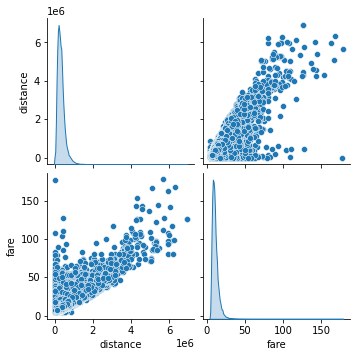

In [7]:
sns.pairplot(train_dataset[["distance", "fare"]], diag_kind="kde")

In [8]:
train_stats = train_dataset.describe()
train_stats.pop('fare')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
distance,748246.0,318613.041312,213087.842539,0.0,182354.94154,280695.910347,400103.70517,6.931296e+06
night,748246.0,0.000740,0.027200,0.0,0.00000,0.000000,0.00000,1.000000e+00
morning,748246.0,0.108844,0.311443,0.0,0.00000,0.000000,0.00000,1.000000e+00
afternoon,748246.0,0.235268,0.424166,0.0,0.00000,0.000000,0.00000,1.000000e+00
evening,748246.0,0.655148,0.475320,0.0,0.00000,1.000000,1.00000,1.000000e+00


In [9]:
train_labels = train_dataset.pop('fare')
test_labels = test_dataset.pop('fare')

In [10]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [11]:
def build_model():
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(1e-3)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [12]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 50

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
  normed_train_data, train_labels, batch_size=256,
  epochs=EPOCHS, validation_split = 0.2, callbacks=[early_stop])

Epoch 1/50
2339/2339 [==============================] - 7s 3ms/step - loss: 20.7031 - mae: 2.7977 - mse: 20.7031 - val_loss: 8.5303 - val_mae: 1.9082 - val_mse: 8.5303
Epoch 2/50
2339/2339 [==============================] - 7s 3ms/step - loss: 8.7064 - mae: 1.8921 - mse: 8.7064 - val_loss: 8.4688 - val_mae: 1.8828 - val_mse: 8.4688
Epoch 3/50
2339/2339 [==============================] - 7s 3ms/step - loss: 8.6748 - mae: 1.8898 - mse: 8.6748 - val_loss: 8.4416 - val_mae: 1.8657 - val_mse: 8.4416
Epoch 4/50
2339/2339 [==============================] - 7s 3ms/step - loss: 8.6413 - mae: 1.8878 - mse: 8.6413 - val_loss: 8.4262 - val_mae: 1.8345 - val_mse: 8.4262
Epoch 5/50
2339/2339 [==============================] - 7s 3ms/step - loss: 8.5614 - mae: 1.8806 - mse: 8.5614 - val_loss: 8.3397 - val_mae: 1.9117 - val_mse: 8.3397
Epoch 6/50
2339/2339 [==============================] - 7s 3ms/step - loss: 8.4547 - mae: 1.8709 - mse: 8.4547 - val_loss: 8.2194 - val_mae: 1.8540 - val_mse: 8.2194
Ep

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [fare]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.75,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$fare^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([7,10])
  plt.legend()
  plt.show()


plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels)

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Fare]')
plt.ylabel('Predictions [Fare]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Fare]")
_ = plt.ylabel("Count")